In [3]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")
import cv2
from copy import deepcopy 
import numpy as np
import matplotlib.pyplot as plt
from CageMaker import load_cv2_RGB
from albumentations.core.transforms_interface import DualTransform
import albumentations
import random

In [3]:
def overlay_mask(mask_bottom, image_top, coordinates):
    height, width, channels = image_top.shape
    result = deepcopy(mask_bottom)
    result[coordinates[0]:(coordinates[0]+height),
           coordinates[1]:(coordinates[1]+width),:]\
           [image_top[:,:,3]!=0]=0
    return result

def overlay_image(image_bottom, image_top, coordinates):
    height, width, channels = image_top.shape
    result = deepcopy(image_bottom)
    alpha_mask = np.broadcast_to(np.reshape(image_top[:,:,3]!=0,
                                            (height,width,1)),
                                 (height,width,3))
    result[coordinates[0]:(coordinates[0]+height),
           coordinates[1]:(coordinates[1]+width),:]\
                [alpha_mask] = image_top[:,:,:3][alpha_mask]
    return result

In [10]:
test_image = load_cv2_RGB("test_image.png")
test_mask = load_cv2_RGB("test_mask.png")
#test_overlay = load_cv2_RGB("Capture.png")
#test_overlay2 = cv2.imread("extra overlays/cropped_overlay.png",
#                          cv2.IMREAD_UNCHANGED)

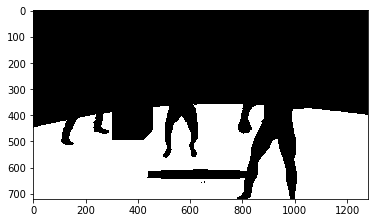

In [5]:
plt.imshow(overlay_mask(test_mask,test_overlay2,[300,300]))

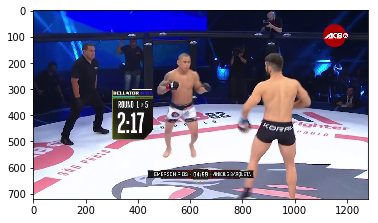

In [6]:
plt.imshow(overlay_image(test_image,test_overlay2,[300,300]))

In [7]:
image_dict = {"Capture.png":[1080,1920],
             "extra overlays/cropped_overlay.png":[1080,1920]}

class RandomInfoOverlay(DualTransform):
    """
        Try something very simple first. Overlays one image above the other
        """
    
    def __init__(self, overlay_dict, max_overlay_num = 5, 
                 always_apply=False, p=1.0):
        super(RandomInfoOverlay,self).__init__(always_apply, p)
        self.overlay_dict = overlay_dict
        self.overlays = {i:cv2.imread(i,cv2.IMREAD_UNCHANGED)\
                         for i in overlay_dict}
        self.max_overlay_num = max_overlay_num
    def __call__(self, force_apply=False, **kwargs):
        
        self.mask = kwargs["mask"]
        self.image = kwargs["image"]
        im_height, im_width, _ = kwargs["image"].shape
        overlay_num = random.randint(1,self.max_overlay_num)
        for i in range(overlay_num):
            index = random.choice(list(self.overlay_dict))
            ref_overlay_height, ref_overlay_width = self.overlay_dict[index]
            overlay_height, overlay_width, _ = self.overlays[index].shape
            overlay = deepcopy(self.overlays[index])
            overlay = albumentations.Resize(
                  int(im_height/ref_overlay_height*overlay_height),
                  int(im_width/ref_overlay_width*overlay_width), p = 1)\
            (image = overlay)["image"] # Resize to target image dimensions
        
            overlay_height, overlay_width, _ = overlay.shape
            coordinate1 = random.randint(0,im_height - overlay_height - 1)
            coordinate2 = random.randint(0,im_width - overlay_width - 1)
            self.mask = overlay_mask(self.mask, overlay,
                                     [coordinate1, coordinate2])
            self.image = overlay_image(self.image, overlay,
                                       [coordinate1, coordinate2])
            
        return super(RandomInfoOverlay,self).__call__(force_apply=force_apply, **kwargs)
    
    def apply(self, img, **params):
        return self.image
    
    def apply_to_mask(self, img, **params):
        return self.mask

In [10]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")
import cv2
import numpy as np
from copy import deepcopy
from CageMaker import default_cage_maker
from albumentations.core.transforms_interface import DualTransform
import random
import albumentations
def overlay_mask2(mask_bottom,image_top):
    height, width, channels = mask_bottom.shape
    overlay = cv2.resize(image_top,(width,height))
    result = deepcopy(mask_bottom)
    alpha_mask = overlay[:,:,3]!=0
    result[alpha_mask] = 0
    return result

def overlay_image2(image_bottom,image_top):
    height, width, channels = image_bottom.shape
    overlay = cv2.resize(image_top,(width,height))
    result = deepcopy(image_bottom)
    alpha_mask = np.broadcast_to(np.reshape(overlay[:,:,3]!=0,
                                            (height,width,1)),
                                 result.shape)
    #print(alpha_mask.shape,result.shape, overlay.shape)
    result[alpha_mask] = overlay[:,:,:3][alpha_mask]
    return result
class RandomCageOverlay(DualTransform):
    """
        Try something very simple first. Overlays one image above the other
        """
    
    def __init__(self, cagemaker, sizes=["XXS","XS","S"],
                 always_apply=False, p=1.0):
        super(RandomCageOverlay,self).__init__(always_apply, p)
        self.cagemaker = cagemaker
        self.sizes = sizes
    
    def __call__(self, force_apply=False, **kwargs):
        size = random.choice(self.sizes)
        self.cropped_overlay = self.cagemaker.get_cage(kwargs["image"],size)
        self.cropped_overlay = albumentations.\
            ShiftScaleRotate(shift_limit=0.3,
                             scale_limit=0.5,
                             rotate_limit=360)(image = self.cropped_overlay)["image"]
        return super(RandomCageOverlay,self).__call__(force_apply=force_apply, **kwargs)
    
    def apply(self, img, **params):
        return overlay_image2(img, self.cropped_overlay)
    
    def apply_to_mask(self, img, **params):
        return overlay_mask2(img, self.cropped_overlay)

default_cage_overlay = RandomCageOverlay(default_cage_maker)




In [11]:
test_aug = RandomInfoOverlay(image_dict,max_overlay_num = 20)

In [12]:
result = default_cage_overlay(image = test_image, mask = test_mask)
result = test_aug(image = result["image"],
                              mask = result["mask"])


True

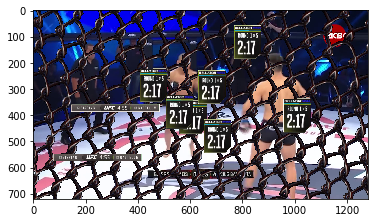

In [13]:
plt.imshow(result["image"])
cv2.imwrite("spoiler2.png",cv2.cvtColor(result["image"], cv2.COLOR_RGB2BGR) )

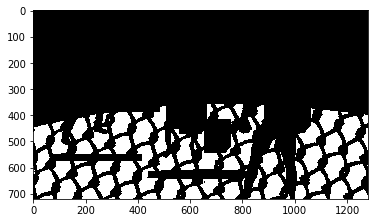

In [14]:
plt.imshow(result["mask"])

In [57]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")
import albumentations
import cv2
import numpy as np
from copy import deepcopy
from PIL import Image

sizes = {"XXS":[3,3],
    "XS":[5,5],
    "S":[10,10],
    "M":[20,20],
    "L":[30,30],
    "XL":[40,40],
}
template = {"cage3.png":[[150,60],[1920, 1080]],
           "extra overlays/cage_crop.png":[[13,8],[1920, 1080]]}
"extra overlays/cage_crop.png"

offsets = [50/4,20/2-2] # Dimensions are flipped
refernce_size = [1920, 1080]  #DImensions are flipped
#template = cv2.imread("extra overlays/cage_crop.png",cv2.IMREAD_UNCHANGED) # Must be loaded with alpha channel

def load_cv2_RGB(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image

def add_horizontal_cell_to_cage(array_cage,array_cell,offset=23*3):
    # offset = 23 by experimentations
    _,cage_width,_ = array_cage.shape
    _,cell_width,_ = array_cell.shape
    image1= np.hstack([array_cage,array_cell])
    image1[:,cage_width:,:]=0
    image1=image1[:,0:(cage_width+cell_width-offset),:]
    image2= np.hstack([array_cage,array_cell])
    image2[:,0:cage_width,:]=0
    image2=image2[:,offset:,:]
    return np.array(Image.alpha_composite(
                                          Image.fromarray(image2),
                                          Image.fromarray(image1)
                                          ))

def add_vertical_cell_to_cage(array_cage,array_cell,offset=40*3):
    # offset = 40 by experimentations, need to work more
    cage_height,_,_ = array_cage.shape
    cell_height,_,_ = array_cell.shape
    image1= np.vstack([array_cage,array_cage])
    image1[cage_height:,:,:]=0
    image1=image1[0:(cage_height+cell_height-offset),:,:]
    image2= np.vstack([array_cage,array_cell])
    image2[0:cage_height,:,:]=0
    image2=image2[offset:,:,:]
    return np.array(Image.alpha_composite(
                                          Image.fromarray(image2),
                                          Image.fromarray(image1)
                                          ))

def make_a_cage(basecell,dimensions, offsets=[23*3,40*3]):
    cage = basecell
    for col in range(1,dimensions[1]):
        cage = add_vertical_cell_to_cage(
                                         cage,
                                         np.flip(basecell,axis = 0),
                                         offsets[1])
    cage_unit=cage
    for row in range(1,dimensions[0]):
        cage = add_horizontal_cell_to_cage(
                                           cage,
                                           cage_unit,
                                           offsets[0]
                                           )
    return cage

class CageMaker():
    def __init__(self, template_dict, sizes):
        self.cages = {}
        for template in template_dict:
            template_image = cv2.imread(template, cv2.IMREAD_UNCHANGED)
            example_cage = {key:self.make_cage(template_image, sizes[key],
                    template_dict[template][0],
                    template_dict[template][1]) for key in sizes}
            self.cages[template] = example_cage
    
    def make_cage(self, template, size, offsets, reference_size):
        dim1, dim2, _ = template.shape
        rescale1 = (reference_size[0]/size[0])/(dim1-offsets[0])
        rescale2 = (reference_size[1]/size[1])/(dim2-offsets[1])
        new_template = cv2.resize(template,(int(dim1*rescale1),
                                            int(dim2*rescale2)),
                                  interpolation = cv2.INTER_LINEAR)
        NCell1 = size[0]+2
        NCell2 = size[1]+2
        offsets = [int(offsets[0]*rescale1),int(offsets[1]*rescale2)]
        result = make_a_cage(new_template,
                        (NCell1,NCell2), offsets).transpose(1,0,2)
        return result

    def get_cage(self,image, size):
        # Get random cage))
        cages = self.cages[random.choice(list(self.cages))]
        template = cages[size]
        template = albumentations.CenterCrop(refernce_size[0],refernce_size[1])\
            (image = template)["image"]
        image = cv2.resize(template,(image.shape[1],image.shape[0]),
                          interpolation = cv2.INTER_AREA)
        return image

default_cage_maker = CageMaker(template, sizes)
default_cage_overlay = RandomCageOverlay(default_cage_maker)

In [19]:
from RandomInfoOverlay import default_info_overlay
from RandomCageOverlay import default_cage_overlay

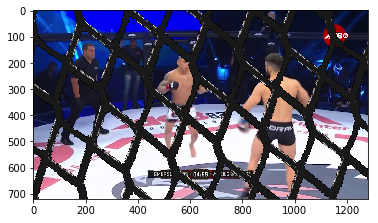

In [23]:
plt.imshow(default_cage_overlay(image = test_image)["image"])

[[1, 'a'],
 [1, 'b'],
 [1, 'c'],
 [2, 'a'],
 [2, 'b'],
 [2, 'c'],
 [3, 'a'],
 [3, 'b'],
 [3, 'c']]